In [1]:
import pandas as pd
from datetime import datetime, timedelta
import cartopy.crs as crs
import cartopy.feature as feat
import matplotlib.pyplot as plt
import numpy as np


In [371]:
latMin = np.mod(36, 360)
latMax = np.mod(48, 360)
lonMin = 46
lonMax = 55
def windowToAxes(window):
    return [window[0]['lon'], window[1]['lon'], window[1]['lat'], window[0]['lat']]

window = [{'lat': latMax, 'lon': lonMax}, {'lat': latMin, 'lon': lonMin}]

In [372]:
# 2021 path has a different CF convention. therefore also changed surface type flag
data2016Path = "./reduced_caspian_2016.csv"
data2017Path = "./reduced_caspian_2017.csv"
data2018Path = "./reduced_caspian_2018.csv"
data2019Path = "./reduced_caspian_2019.csv"
data2020Path = "./reduced_caspian_2020.csv"
data2021Path = "./reduced_caspian_2021.csv"

surface_type_flag = 2


df2016 = pd.read_csv(data2016Path)
df2017 = pd.read_csv(data2017Path)
df2018 = pd.read_csv(data2018Path)
df2019 = pd.read_csv(data2019Path)
df2020 = pd.read_csv(data2020Path)
df2021 = pd.read_csv(data2021Path)

## Plot a sample

[ 91. 105. 132. 167. 208. 234. 243.  15.  29.  56.  65.  13. 207.]


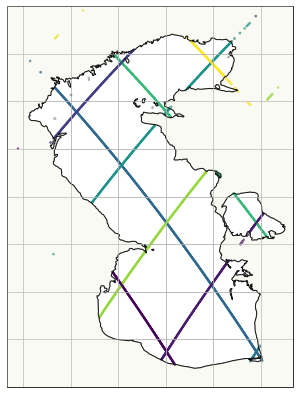

In [380]:
df = df2020

data = df.loc[(df.month == 11) & (df["surface type"] == 2)]

fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=crs.PlateCarree())
ax.set_extent(windowToAxes(window))
ax.add_feature(feat.LAND, zorder=100, edgecolor='k', alpha=0.3)
ax.coastlines()
ax.scatter(x=data["lon"], y=data["lat"], c=data["pass number"], s=2, transform=crs.PlateCarree(central_longitude=0))
ax.gridlines(draw_labels=False)

print(data["pass number"].unique())

# Find intersecting points

In [5]:
days = [x for x in range(1, 32)]
months = [1,2,3,4,5,6,7,8,9,10,11,12]
dataset = []
monthly = []
datasets = [df2016, df2017, df2018, df2019, df2020, df2021]
surfaceTypeFlags = [1, 1, 1, 1, 1, 2] # Flags corresponding to the correct dataset (CF-1.* Notation)

for index, df in enumerate(datasets):
    print("dataset: {}".format(df.year.values[0]))
    for month in months:
        d = []
        surfaceType = surfaceTypeFlags[index]

        if str(df.year.values[0]) == "2016" and month < 7:
            print("Skipping month:", month)
            continue
            
        if str(df.year.values[0]) == "2020" and month >= 11:
            print("Skipping month:", month)
            surfaceType = 2
        
        data = df.loc[(df.month == month) & (df["surface type"] ==surfaceType )]

        
        print("Calculating for month:", month)

        
        # Create a list of pass numbers that has usable intersections
        passNumbersWithIntersections = [(91, 207), (91, 29), (91, 56), (91, 133), (15, 29), (15, 207), (167, 56), (243, 133)]

        # Find an intersection points between pass number
        for intersection in passNumbersWithIntersections:
            p1 = data.loc[(df["pass number"] == intersection[0])]
            p2 = data.loc[(df["pass number"] == intersection[1])]

            if (intersection[1] == 133):
                p2 = data.loc[(df["pass number"] == intersection[1]) | (df["pass number"] == 132) | (df["pass number"] == 131)]
            if (intersection[1] == 207):
                p2 = data.loc[(df["pass number"] == intersection[1]) | (df["pass number"] == 208)]
            if (intersection[1] == 56):
                p2 = data.loc[(df["pass number"] == intersection[1]) | (df["pass number"] == 55)]

            v1 = np.column_stack(([p1["lat"].values, p1["lon"].values]))
            v2 = np.column_stack(([p2["lat"].values, p2["lon"].values]))

            distances = []
            indices = []
            for i, point in enumerate(v1):
                # Calculate distance to point in v2
                for j, point2 in enumerate(v2):
                    dist = np.linalg.norm(point - point2)
                    distances.append(dist)
                    indices.append((i, j))
            try:
                min_value = min(distances)
            except ValueError as e:
                print("Val error: ",e, intersection, month)
                break
            min_index = distances.index(min_value)

            k = indices[min_index]
            n = 3
            i1 = [x for x in range(k[0]-n, k[0]+n)]
            i2 = [x for x in range(k[1]-n, k[1]+n)]
            d.append(pd.concat([p1.iloc[i1], p2.iloc[i2]]))
        monthly.append(d)
    dataset.append(monthly)
print("Finished")

dataset: 2016
Skipping month: 1
Skipping month: 2
Skipping month: 3
Skipping month: 4
Skipping month: 5
Skipping month: 6
Calculating for month: 7
Calculating for month: 8
Calculating for month: 9
Calculating for month: 10
Calculating for month: 11
Calculating for month: 12
dataset: 2017
Calculating for month: 1
Calculating for month: 2
Calculating for month: 3
Calculating for month: 4
Calculating for month: 5
Calculating for month: 6
Calculating for month: 7
Calculating for month: 8
Calculating for month: 9
Calculating for month: 10
Calculating for month: 11
Calculating for month: 12
dataset: 2018
Calculating for month: 1
Calculating for month: 2
Calculating for month: 3
Calculating for month: 4
Calculating for month: 5
Calculating for month: 6
Calculating for month: 7
Calculating for month: 8
Calculating for month: 9
Calculating for month: 10
Calculating for month: 11
Calculating for month: 12
dataset: 2019
Calculating for month: 1
Calculating for month: 2
Calculating for month: 3
Ca

# Create a new dataframe which contains only points near the intersections

In [317]:
averagedSSH = []
averagedMSS = []
SSH = np.zeros((0,0))
MSS = np.zeros((0,0))

dataframes = []
for i, m in enumerate(monthly):
    levels = []
    ranges = []
    altitudes = []
    for i, intersection in enumerate(m):
        ranges.append(intersection.range.values)
        altitudes.append(intersection.altitude.values)
        levels.append(intersection.mss.values)
        dataframes.append(intersection)
        
    
    rng = np.array(ranges).flatten()
    alt = np.array(altitudes).flatten()
    rngAlt = np.column_stack([rng, alt])
    rngAlt = np.delete(rngAlt, np.where(rngAlt[:,0] > 1.349699e+07)[0], axis=0)
    diff = (rngAlt[:,1] - rngAlt[:,0] )
    
    mss = np.array(levels).flatten()
    mss = np.delete(mss, np.where(mss > 1.349699e+07)[0], axis=0)

    averagedSSH.append(np.mean(diff))
    averagedMSS.append(np.mean(mss))
    
    SSH = np.append(SSH, np.array(diff).flatten())
    MSS = np.append(MSS, mss)



# Create a dataframe which separates intersections

In [343]:
intersectionListMean = []
for i, m in enumerate(monthly):
    intersectionMeans = []
    
    for i, intersection in enumerate(m):
        sshList = []
        for x in range(len(intersection.range.values)):
            if (intersection.range.values[x] > 1.349699e+07):
                continue
            ssh = intersection.altitude.values[x] - intersection.range.values[x]
            sshList.append(ssh)
        if (len(sshList)) < 1:
            sshList.append(np.nan)
        intersectionMeans.append(np.mean(np.array(sshList)))

    intersectionListMean.append(intersectionMeans)

intersectionListMean = np.array(intersectionListMean)



In [344]:
dfinter = pd.DataFrame(intersectionListMean)
dfinter.columns = ["Intersection 1","Intersection 2", "Intersection 3", "Intersection 4", "Intersection 5", "Intersection 6", "Intersection 7", "Intersection 8", ]

dfinter.fillna(method='ffill', inplace=True)
dfinter["avg"] = dfinter.sum(axis=1, skipna=True) / 8
dfinter["month"] = dfinter.index + 7
dfinter["year"] = 2016

for i, month in enumerate(dfinter["month"]):
    dfinter.loc[dfinter['month'] > 12, "year"] = 2017
    dfinter.loc[dfinter['month'] > 24, "year"] = 2018
    dfinter.loc[dfinter['month'] > 36, "year"] = 2019
    dfinter.loc[dfinter['month'] > 48, "year"] = 2020

    dfinter.loc[dfinter['month'] > 60, "year"] = 2021
    

dfinter["month"] = dfinter["month"].apply(lambda x: 12 if ((x % 12) == 0) else x % 12)


## Plot averaged SSH

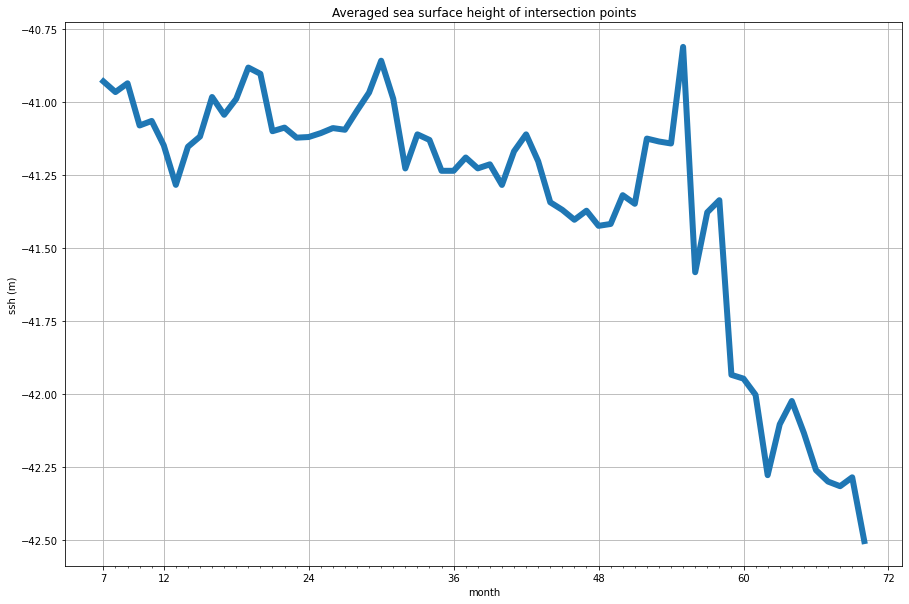

In [350]:
offset = 7

plt.rcParams['figure.figsize'] = [15, 10]

major_ticks = [7, 12, 24, 36, 48, 60, 72]
minor_ticks = np.arange(offset, len(monthly)+offset, 1)


fig, ax = plt.subplots()
ax.plot(dfinter.index + offset, dfinter.avg.values,
       linewidth=6)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.set(xlabel='month', ylabel='ssh (m)',
       title='Averaged sea surface height of intersection points')
ax.grid()

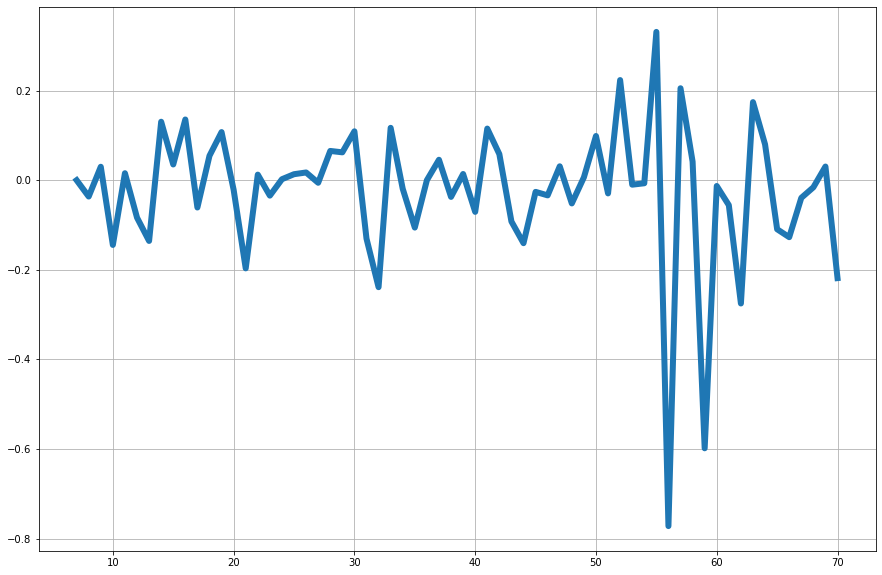

In [351]:
# Difference Transform

# difference dataset
def difference(data, interval):
    d = [0] * len(data)
    for i in range(interval, len(data)):
        d[i] = data[i] - data[i - interval]
    return d

# invert difference
def invert_difference(orig_data, diff_data, interval):
    d = [0] * len(orig_data)
    for i in range(interval, len(orig_data)):
        d[i] = diff_data[i-interval] + orig_data[i-interval]
    d[0] = d[1]
    return d
 
    
# difference transform
transformed = difference(dfinter.avg.values, 1)
dfinter["avg_transformed_ssh"] = transformed
fig, ax = plt.subplots()

ax.plot(dfinter.index + offset, transformed,
       linewidth=6)

ax.grid()

plt.show()

In [57]:
# Revert data

inverted = invert_difference(dfinter.avg.values, transformed, 1)

#fig, ax = plt.subplots()

#ax.plot(dfinter.index + offset, inverted,linewidth=6)
#ax.grid()

#plt.show()

# PLOT SSH For each Intersection

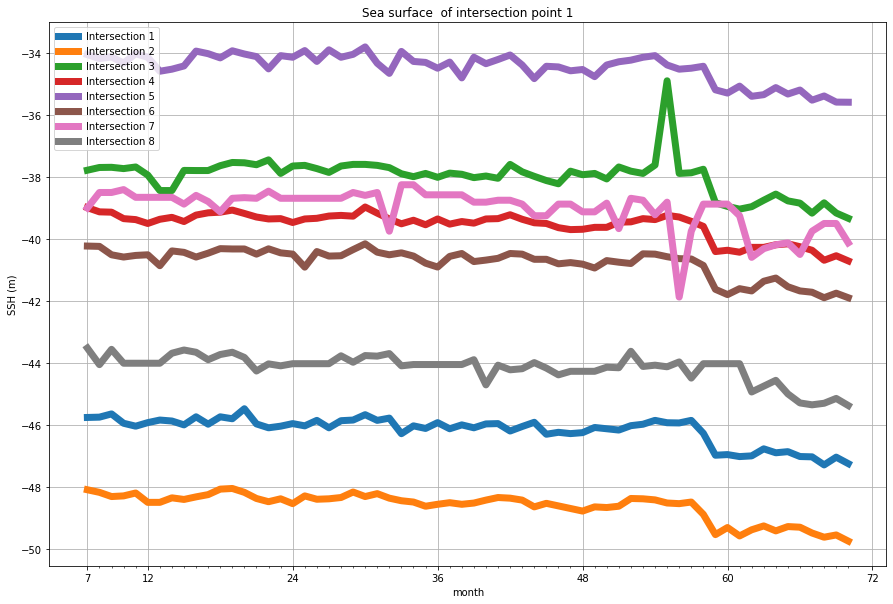

In [352]:
from cycler import cycler

plt.rcParams['figure.figsize'] = [15, 10]

minor_ticks = np.arange(offset, len(monthly)+offset, 1)

fig, ax = plt.subplots()
offset = 7

for i in range(len(intersectionListMean[0])):
    ax.plot(dfinter.index + offset, dfinter.iloc[:,i]
            ,linewidth=7
            ,label=str(dfinter.columns[i]))
    

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.set(xlabel='month', ylabel='SSH (m)',
       title='Sea surface  of intersection point 1')
plt.legend(loc="upper left")
plt.savefig("ssh_intersections.png")
ax.grid()

# Average all intersections and plot mss for whole Caspian

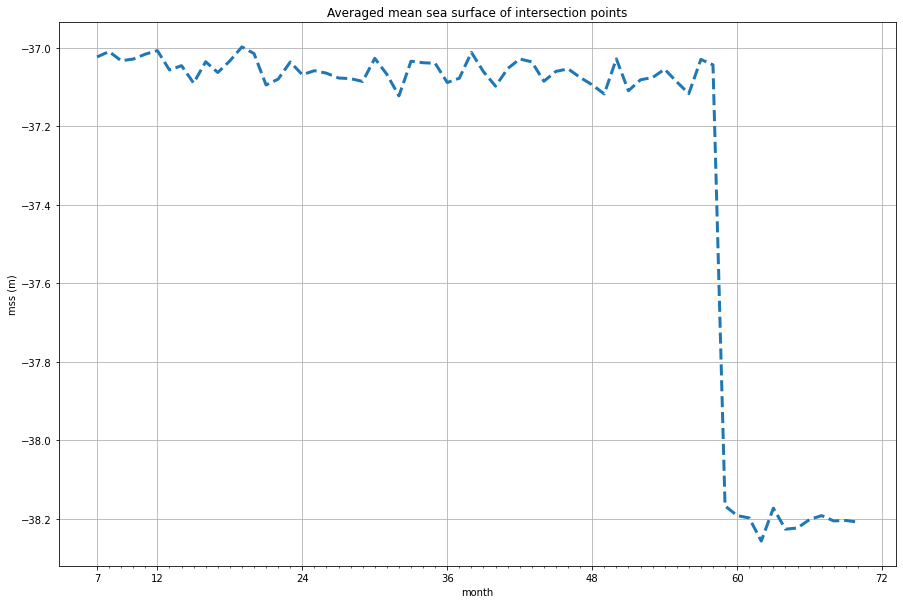

In [354]:
fig, ax = plt.subplots()
ax.plot(np.arange(offset, len(monthly)+offset, 1), averagedMSS,
       linestyle='dashed',
       linewidth=3)

ax.set_xticks(major_ticks)
ax.set_xticks(minor_ticks, minor=True)

ax.set(xlabel='month', ylabel='mss (m)',
       title='Averaged mean sea surface of intersection points')
ax.grid()


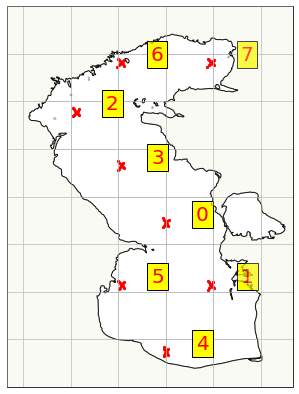

In [119]:
fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=crs.PlateCarree())
ax.set_extent(windowToAxes(window))
ax.add_feature(feat.LAND, zorder=100, edgecolor='k', alpha=0.3)
ax.coastlines()

for i, serie in enumerate(d):
    ax.scatter(x=serie["lon"], y=serie["lat"], c="red", s=5,  transform=crs.PlateCarree(central_longitude=0))
    plt.text(x=serie["lon"].iloc[1] + 1,
             y=serie["lat"].iloc[1]
             ,s=str(i), 
          fontdict=dict(color="red",size=20),
          bbox=dict(facecolor="yellow",alpha=1))


ax.gridlines(draw_labels=False)
plt.savefig("ssh_intersections_names.png")


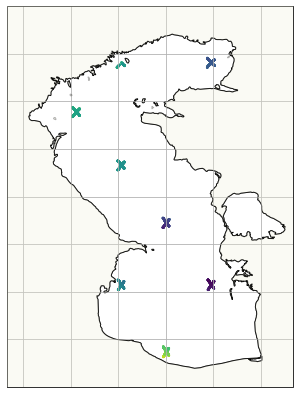

In [118]:
dfRangeFiltered = df.loc[(df["range"] < 1.349699e+07)]
rngAlt = np.column_stack([dfRangeFiltered["range"].values, dfRangeFiltered["altitude"].values])
diff = (rngAlt[:,1] - rngAlt[:,0] )

fig = plt.figure(figsize=(12, 7))
ax = plt.axes(projection=crs.PlateCarree())
ax.set_extent(windowToAxes(window))
ax.add_feature(feat.LAND, zorder=100, edgecolor='k', alpha=0.3)
ax.coastlines()
ax.scatter(x=dfRangeFiltered["lon"], y=dfRangeFiltered["lat"], c=diff, s=2, transform=crs.PlateCarree(central_longitude=0))
ax.gridlines(draw_labels=False)



In [355]:
# Create a collected dataframe from all datasets
df = pd.concat(dataframes)

# But drop rows where range is not providing usefull values
df = df.drop(df[df.range >  1.349699e+07].index)

sum_column = df["altitude"] - df["range"] 
df["ssh"] = sum_column

dfinter

,Intersection 1,Intersection 2,Intersection 3,Intersection 4,Intersection 5,Intersection 6,Intersection 7,Intersection 8,avg,month,year,avg_transformed_ssh
0,-45.760417,-48.093750,-37.781250,-38.989583,-34.052083,-40.229167,-39.00000,-43.520833,-40.928385,7,2016,0.000000
1,-45.750000,-48.177083,-37.693182,-39.125000,-34.178571,-40.239583,-38.50000,-44.055556,-40.964872,8,2016,-0.036487
2,-45.645833,-48.312500,-37.687500,-39.135417,-34.125000,-40.510417,-38.50000,-43.562500,-40.934896,9,2016,0.029976
3,-45.947917,-48.291667,-37.729167,-39.343750,-34.322917,-40.583333,-38.40625,-44.010417,-41.079427,10,2016,-0.144531
4,-46.041667,-48.197917,-37.677083,-39.375000,-34.020833,-40.531250,-38.65625,-44.010417,-41.063802,11,2016,0.015625
...,...,...,...,...,...,...,...,...,...,...,...,...
59,-47.020833,-49.302083,-38.843750,-40.250000,-35.193182,-41.677083,-40.50000,-45.291667,-42.259825,6,2021,-0.127131
60,-47.031250,-49.489583,-39.166667,-40.364583,-35.520833,-41.718750,-39.75000,-45.352273,-42.299242,7,2021,-0.039418
61,-47.291667,-49.625000,-38.833333,-40.687500,-35.385417,-41.895833,-39.50000,-45.302083,-42.315104,8,2021,-0.015862
62,-47.041667,-49.552083,-39.162500,-40.541667,-35.583333,-41.750000,-39.50000,-45.145833,-42.284635,9,2021,0.030469


## Features and Labels

In [89]:
# Labels are the values we want to predict
labels = np.array(df['transformed_mss'])

# Remove the labels from the features
# axis 1 refers to the columns
features= df.drop('transformed_mss', axis = 1)
# Drop unused columns as well
features = features.drop(['surface type', "pass number", "geophysical quality flag", "time", "range", "altitude", "ssh", "mss"], axis= 1)

# Saving feature names for later use
feature_list = list(features.columns)
print(feature_list)
# Convert to numpy array
features = np.array(features)

['lat', 'lon', 'day', 'month', 'year']


### Attempt 2: Using only meaned SSH for each intersection

In [356]:
# Labels are the values we want to predict
labels = np.array(dfinter['avg_transformed_ssh'])

# Remove the labels from the features
# axis 1 refers to the columns
features= dfinter.drop('avg_transformed_ssh', axis = 1)
# Drop unused columns as well
features = features.drop(["Intersection 1","Intersection 2", "Intersection 3", "Intersection 4", "Intersection 5", "Intersection 6", "Intersection 7", "Intersection 8", "avg" ]
, axis= 1)

# Saving feature names for later use
feature_list = list(features.columns)
print(feature_list)
# Convert to numpy array
features = np.array(features)

['month', 'year']


## Training and test sets

In [357]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25)

In [358]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (48, 2)
Training Labels Shape: (48,)
Testing Features Shape: (16, 2)
Testing Labels Shape: (16,)


## Training the Forest

In [359]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
rf = RandomForestRegressor(n_estimators= 2000, bootstrap=True)

# Train the model on training data
rf.fit(train_features, train_labels);

# Predictions

In [360]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Calculate the absolute errors
errors = abs(predictions - test_labels)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4) * 100, 'cm')

Mean Absolute Error: 12.31 cm


# Visualize a single tree

In [361]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot

# Pull out one tree from the forest
tree = rf.estimators_[5]

# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')

# Write graph to a png file
graph.write_png('tree.png'); 

![Decision Tree](tree.png)

In [254]:
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 7


# Predicting in the future and plotting using location and date

In [76]:
import random
from dateutil.relativedelta import relativedelta

date_from = datetime(2016, 8, 1)
dateTimes = []
year = []
month = []
day = []
lat = []
lon = []

years = 15

for x in range(12 * years):
    date = date_from + relativedelta(months=+x)
    dateTimes.append(date)
    year.append(date.year)
    month.append(date.month)
    day.append(date.day)
    
    lon.append(random.uniform(46, 55))
    lat.append(random.uniform(36, 48))
    
    #lon.append(49)
    #lat.append(38)

res = np.column_stack([lat, lon, day, month, year])
future_pred = rf.predict(res)

dfTest = pd.DataFrame(res)
dfTest.columns = ["lat", "lon", "day", "month", "year"]


120000

In [82]:
dfTrain = df.drop(['surface type', "pass number", "geophysical quality flag", "time", "range", "altitude", "ssh" , "mss"], axis= 1)
dfActual =  df.drop(['surface type', "pass number", "geophysical quality flag", "time", "range", "altitude", "ssh" ], axis= 1)
dfTrain = dfTrain.sample(n=res.shape[0])

current_pred = rf.predict(np.array(dfTrain))

dfActual = dfActual.sample(n=100)
dfActual.sort_values(by=['year','month', 'day'], inplace=True)

dfActual = dfActual.loc[(dfActual['lat'] >= 36) & (dfActual['lat'] <= 48)]
dfActual = dfActual.loc[(dfActual['lon'] >= 46) & (dfActual['lon'] <= 55)]

actualDateTimes = []
actualMSS = []
for x in range(len(dfActual["day"].values)):

    date = datetime(int(dfActual["year"].values[x]), int(dfActual["month"].values[x]), int(dfActual["day"].values[x]))
    actualDateTimes.append(date)
    actualMSS.append(dfActual["mss"].values[x])


ValueError: Cannot take a larger sample than population when 'replace=False'

NameError: name 'actualDateTimes' is not defined

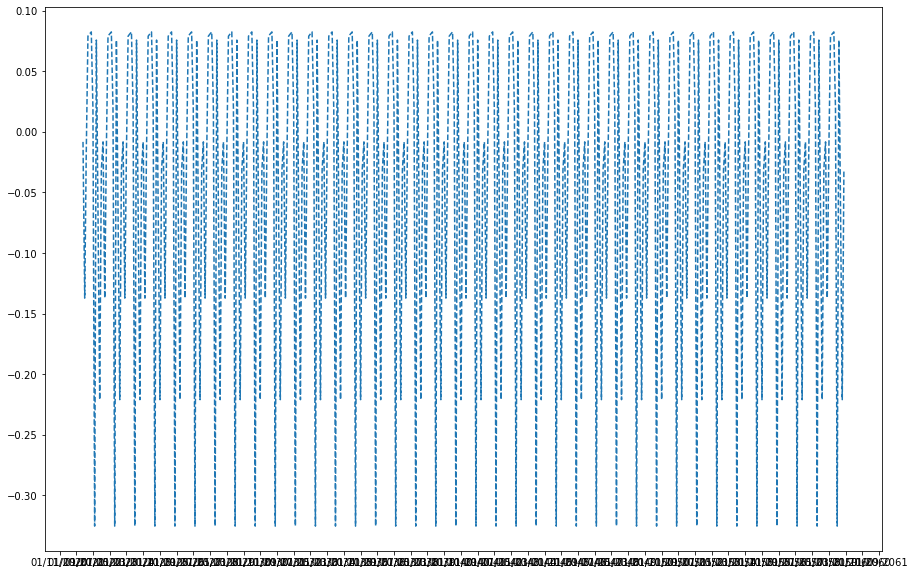

In [196]:
# Plot the actual values
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=10))


x = [x for x in range(1,  len(future_pred) + 1)]

#major_ticks = [1, 12, 24, 36, 48, 60, 72, 84, 96]
#minor_ticks = np.arange(1, len(future_pred), 1)

#fig, ax = plt.subplots()
#offset = 7

#ax.plot(x, future_pred, '--', label = 'predicted')


plt.plot(dateTimes,future_pred, "--", label ="predicted")


plt.plot(actualDateTimes,actualMSS, label ="Actual")


x = [x for x in range(1,  len(dfTrain["lat"].values) + 1)]
#ax.plot(x, current_pred, '--', label = 'Current')


#ax.set_xticks(major_ticks)
#ax.set_xticks(minor_ticks, minor=True)
plt.gcf().autofmt_xdate()

plt.legend()

# Graph labels
#plt.xlabel('Date'); plt.ylabel('Mean Sea Surface'); plt.title('Actual and Predicted Values');

In [ ]:
# Creating images

In [324]:
df.head()

,lat,lon,time,mss,surface type,range,altitude,geophysical quality flag,pass number,day,month,year,ssh
25687,41.318970,50.910027,521321856.0,-41.764000,1.0,1347102.625,1347057.375,127.0,91.0,8,7,2016,-45.250
25688,41.273151,50.944695,521321856.0,-41.878601,1.0,1347088.375,1347043.000,127.0,91.0,8,7,2016,-45.375
25689,41.227322,50.979305,521321856.0,-41.988800,1.0,1347074.125,1347028.625,127.0,91.0,8,7,2016,-45.500
25690,41.181477,51.013866,521321856.0,-42.093800,1.0,1347059.875,1347014.250,127.0,91.0,8,7,2016,-45.625
25691,41.135620,51.048370,521321856.0,-42.200100,1.0,1347045.625,1346999.875,127.0,91.0,8,7,2016,-45.750


In [78]:
date_from = datetime(3099, 1, 1)
dateTimes = []
year = []
month = []
day = []
lat = []
lon = []

years = 1

for x in range(12 * years):
    for samples in range(10000):
        date = date_from + relativedelta(months=+x)
        dateTimes.append(date)
        year.append(date.year)
        month.append(date.month)
        day.append(date.day)

        lon.append(random.uniform(46, 55))
        lat.append(random.uniform(36, 48))
    
    #lon.append(49)
    #lat.append(38)

res = np.column_stack([lat, lon, day, month, year])
future_pred = rf.predict(res)

dfTest = np.column_stack([res, future_pred])

dfTest = pd.DataFrame(dfTest)
dfTest.columns = ["lat", "lon", "day", "month", "year", "mss"]
dfTest.head()

,lat,lon,day,month,year,mss
0,45.623868,54.611053,1.0,1.0,3099.0,-0.083080
1,43.464842,54.692037,1.0,1.0,3099.0,-0.487292
2,39.999799,51.686118,1.0,1.0,3099.0,-3.980246
3,37.465706,54.857445,1.0,1.0,3099.0,-0.026099
4,40.795334,47.894205,1.0,1.0,3099.0,3.338035


In [79]:
from scipy.interpolate import Rbf

def interpolateRBF(x, y, z, func='linear'):
    radialBasis = Rbf(x, y, z, function=func)

    x_new = np.linspace(np.amin(x), np.amax(x), x.shape[0])
    y_new = np.linspace(np.amin(y), np.amax(y), y.shape[0])

    x_grid, y_grid = np.meshgrid(x_new, y_new)
    z_new = radialBasis(x_grid.ravel(), y_grid.ravel()).reshape(x_grid.shape)

    return x_new, y_new, z_new

Creating month 1
Min 36.011450696613856 max 48.117797294801555
Creating month 2
Min 36.0055014855857 max 48.48451927884979
Creating month 3
Min 36.01637826308777 max 48.68479819177951
Creating month 4
Min 36.028024229768626 max 48.378177498090494
Creating month 5
Min 36.002850286327075 max 48.84770802986252
Creating month 6
Min 36.006188839634675 max 48.37710844665111
Creating month 7
Min 36.019738563749726 max 48.9385571857486
Creating month 8
Min 36.004655420717796 max 48.40776604464727
Creating month 9
Min 36.02008073954655 max 48.824098182697135
Creating month 10
Min 36.004609430067966 max 49.01177111963389
Creating month 11
Min 36.007067110935196 max 48.91995553769148
Creating month 12
Min 36.018993628963536 max 48.67324398976048


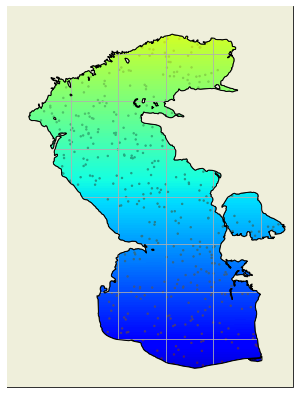

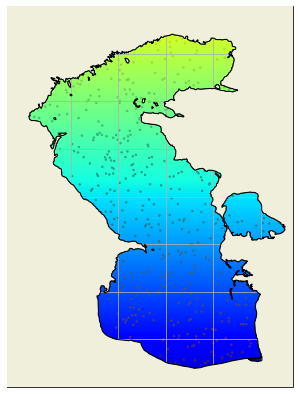

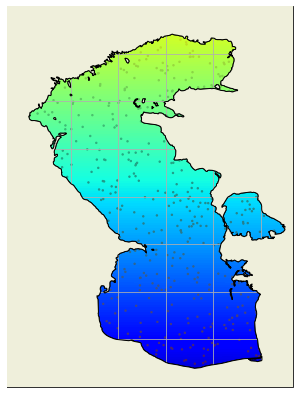

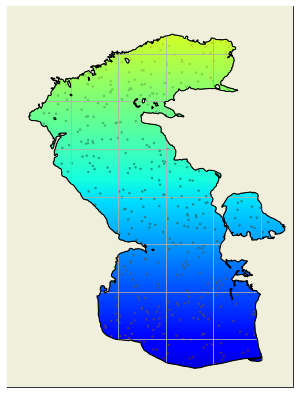

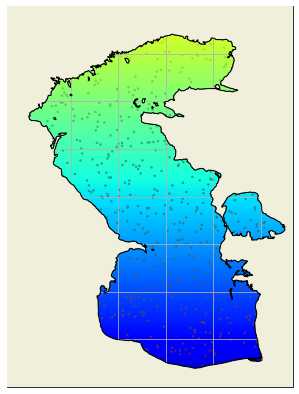

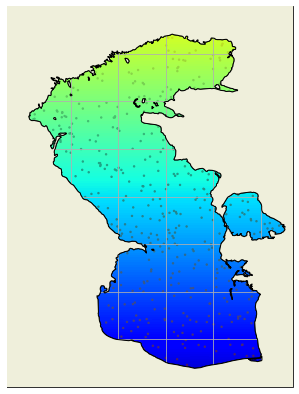

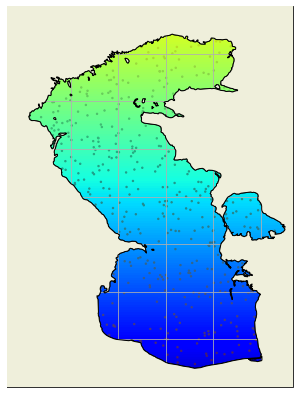

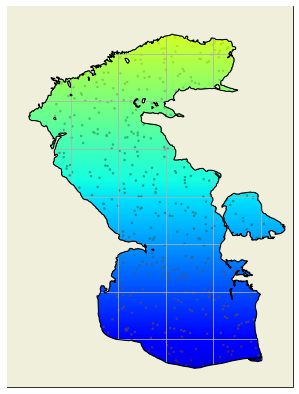

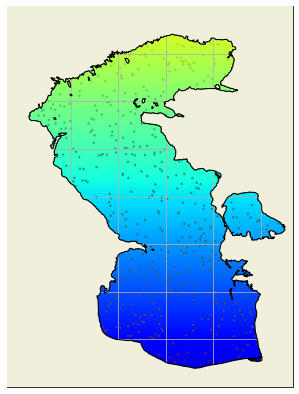

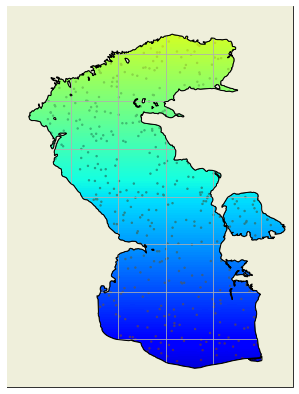

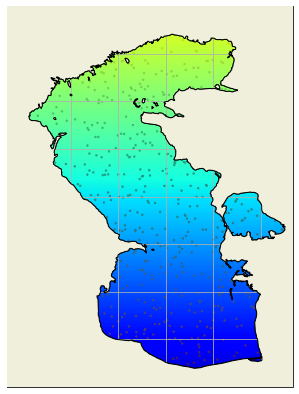

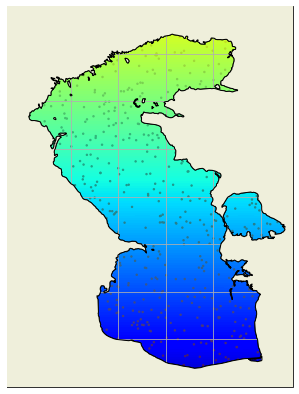

In [80]:
for year in range(3099, 3100):
    for x in range(1, 13):
        print("Creating month {}".format(x))
        data = dfTest.loc[(dfTest.year == year) &(dfTest.month == x) ]

        n = 10
        longitudes = data["lon"].values[::n]
        latitudes = data["lat"].values[::n]
        mss = data["lat"].values[::n]

        _, _, imgInter = interpolateRBF(longitudes, latitudes, mss)
        imgInter = np.rot90(imgInter, 2)

        print("Min {} max {}".format(np.min(imgInter), np.max(imgInter)))

        fig = plt.figure(figsize=(12, 7))
        ax = plt.axes(projection=crs.PlateCarree())
        ax.set_extent(windowToAxes(window))
        ax.add_feature(feat.LAND, zorder=100, edgecolor='k', alpha=1)
        ax.coastlines()

        ax.imshow(imgInter, vmin=35, vmax=55, cmap="jet", extent=windowToAxes(window),
                      transform=crs.PlateCarree(central_longitude=0))

        ax.scatter(x=longitudes, y=latitudes, c=mss, s=2, transform=crs.PlateCarree(central_longitude=0))

        #ax.scatter(x=data["lon"], y=data["lat"], c=data["mss"], s=2, transform=crs.PlateCarree(central_longitude=0))
        ax.gridlines(draw_labels=False)
        plt.savefig('mss_pred_inter_'+str(year) +  "_" +str(x)+'.png')



# Predicting future and Plotting averaged across all intersections

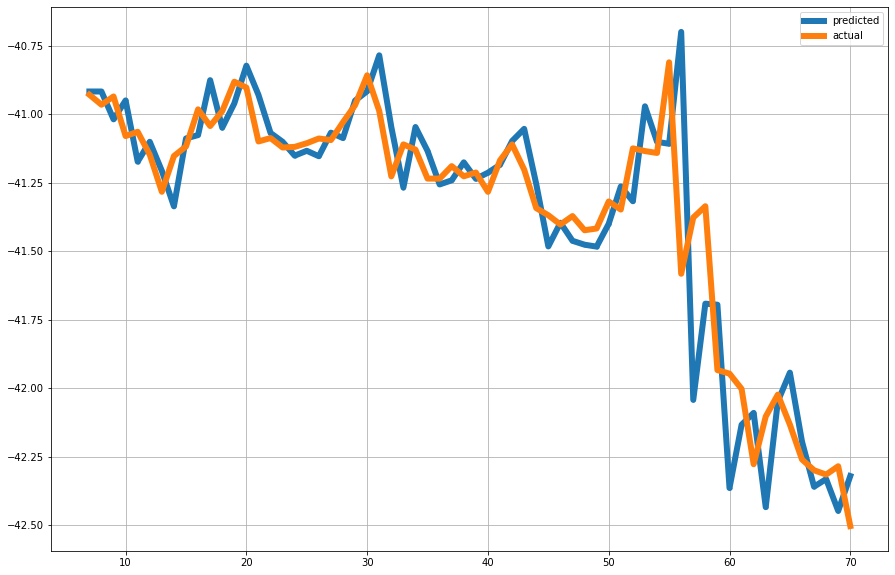

In [362]:
predicted_mss =  rf.predict(features)
inverted = invert_difference(dfinter["avg"].values, predicted_mss, 1)
transformed = difference(dfinter["avg"].values, 1)
fig, ax = plt.subplots()

x = np.arange(0, len(features),1)
ax.plot(x + offset, inverted, ".-", label="predicted", linewidth=6)
ax.plot(x + offset, dfinter["avg"].values, label="actual", linewidth=6)

ax.grid()
ax.legend()

plt.savefig("predicted_actual_inverted.png")
plt.show()

In [363]:
date_from = datetime(2030, 1, 1)
dateTimes = []
year = []
month = []


years = 10

for x in range(12 * years):
    date = date_from + relativedelta(months=+x)
    dateTimes.append(date)
    year.append(date.year)
    month.append(date.month)
        
res = np.column_stack([month, year])
future_pred = rf.predict(res)

dfTest = np.column_stack([res, future_pred])

dfTest = pd.DataFrame(dfTest)
dfTest.columns = ["month", "year", "avg_transformed_ssh"]
dfTest.head(5)

,month,year,avg_transformed_ssh
0,1.0,2030.0,-0.087557
1,2.0,2030.0,-0.156636
2,3.0,2030.0,0.055256
3,4.0,2030.0,0.080299
4,5.0,2030.0,-0.061517


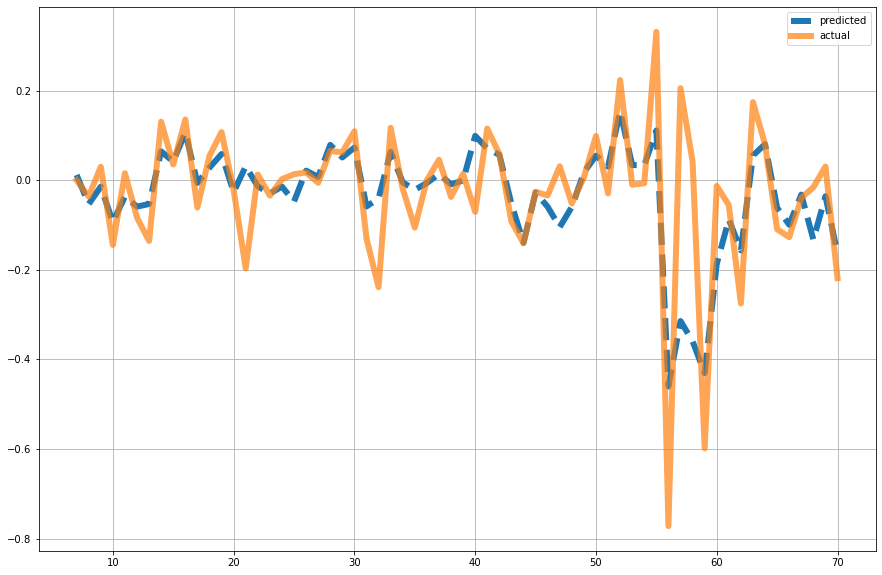

In [364]:
predicted_mss =  rf.predict(features)
inverted = invert_difference(dfinter["avg"].values, predicted_mss, 1)
transformed = difference(dfinter["avg"].values, 1)
fig, ax = plt.subplots()

x = np.arange(0, len(features),1)
ax.plot(x + offset, predicted_mss, "--", label="predicted", linewidth=6)
ax.plot(x + offset, transformed, "", label="actual", linewidth=6, alpha=0.7)

ax.grid()
ax.legend()

plt.savefig("predicted_actual_transformed.png")

plt.show()

In [365]:
# Create predictions

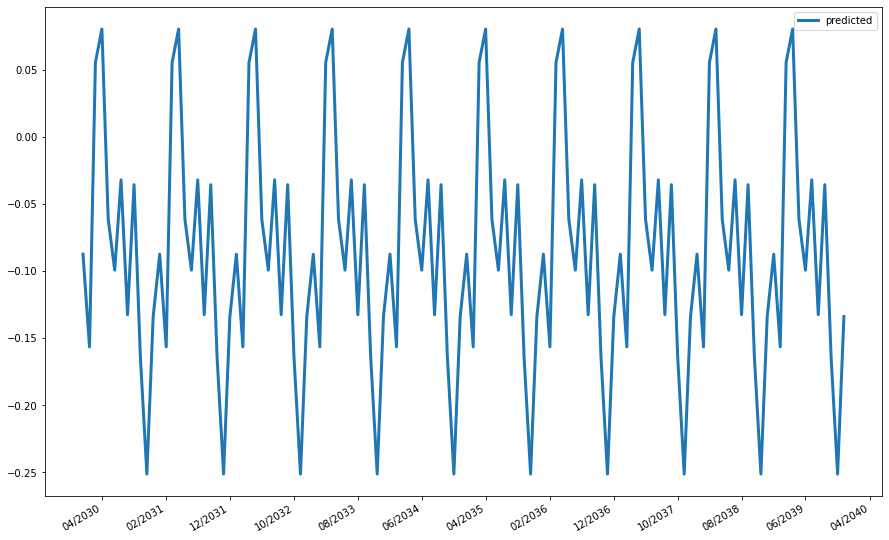

In [366]:
predicted_mss =  rf.predict(features)
inverted = invert_difference(dfinter["avg"].values, predicted_mss, 1)

fig, ax = plt.subplots()

axis_x = np.arange(0, len(dfTest["year"].values),1)
#ax.plot(x + offset,  predicted_mss, "--", label="predicted", linewidth=6)
#ax.plot(x + offset, dfinter["avg"].values, ".-.", label="actual", linewidth=6)

# Plot the actual values
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=10))

actualDateTimes = []
actualMSS = []
for x in range(len(dfTest["year"].values)):
    date = datetime(int(dfTest["year"].values[x]), int(dfTest["month"].values[x]), 1)
    actualDateTimes.append(date)
    
plt.plot(actualDateTimes,dfTest["avg_transformed_ssh"].values, "", label ="predicted", linewidth=3)


plt.gcf().autofmt_xdate()

plt.legend()
plt.savefig("predicted_transformed_2030_2035.png")

plt.show()

In [367]:
df.head()
# month 168 to 288 for year 2030 to 2040 with linear model
month2030To2040 = np.arange(168, 288, 1)
print(month2030To2040)
print(len(month2030To2040))

[168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275
 276 277 278 279 280 281 282 283 284 285 286 287]
120


alpha = -41.25724170461369
beta = -0.0006768725116946184


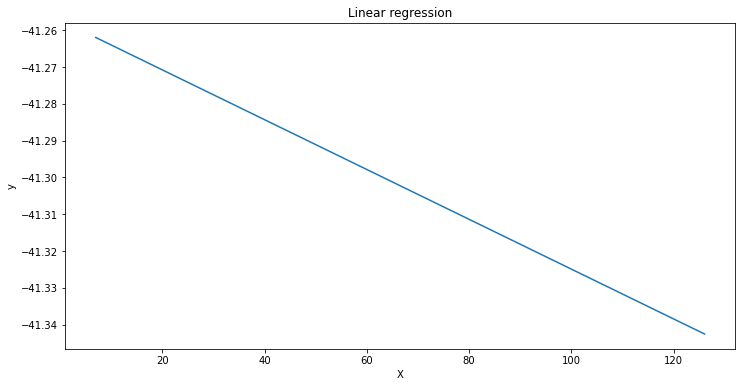

In [368]:
# Create linear model from 2016-2021 data

df = pd.DataFrame(np.array([np.arange(0, len(dfinter["avg"].values),1), dfinter["avg"].values]).T)
df.columns = ["X", "y"]
# Calculate the mean of X and y
xmean = np.mean(x + offset)
ymean = np.mean(dfinter["avg"].values)

# Calculate the terms needed for the numator and denominator of beta
df['xycov'] = (df['X'] - xmean) * (df['y'] - ymean)
df['xvar'] = (df['X'] - xmean)**2

# Calculate beta and alpha
beta = df['xycov'].sum() / df['xvar'].sum()
alpha = ymean - (beta * xmean)
print(f'alpha = {alpha}')
print(f'beta = {beta}')

X = axis_x + offset
ypred = alpha + beta *X 

# Plot regression against actual data
plt.figure(figsize=(12, 6))
plt.plot(X, ypred)     # regression line
plt.title('Linear regression')
plt.xlabel('X')
plt.ylabel('y')

plt.show()


In [369]:
print(len(X))

120


(120,)
120


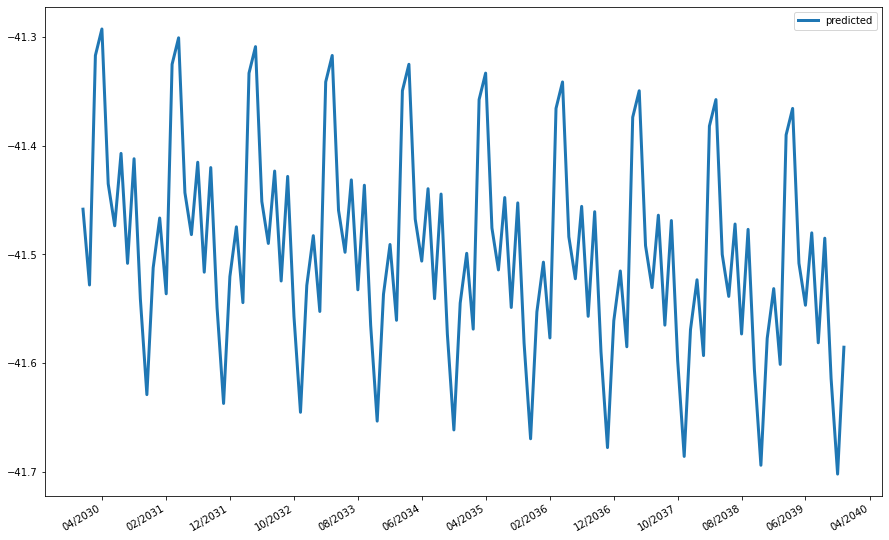

In [370]:
fig, ax = plt.subplots()

x = np.arange(0, len(features),1)
#ax.plot(x + offset,  predicted_mss, "--", label="predicted", linewidth=6)
#ax.plot(x + offset, dfinter["avg"].values, ".-.", label="actual", linewidth=6)

# Plot the actual values
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=10))

actualDateTimes = []
actualMSS = []
for x in range(len(dfTest["year"].values)):
    date = datetime(int(dfTest["year"].values[x]), int(dfTest["month"].values[x]), 1)
    actualDateTimes.append(date)

print(dfTest["avg_transformed_ssh"].values.shape)
print(len(X))

ypred = alpha + beta * month2030To2040 + dfTest["avg_transformed_ssh"].values
ypred_fail = alpha + beta * X + dfTest["avg_transformed_ssh"].values

plt.plot(actualDateTimes,ypred, "", label ="predicted", linewidth=3)

#plt.plot(actualDateTimes,ypred_fail, "", label ="failed", linewidth=3)

plt.gcf().autofmt_xdate()

plt.legend()
plt.savefig("predicted_transformed_2030_2035_with_linear.png")

plt.show()